# LTV Predictions

In [550]:
import numpy as np
import pandas as pd
import re
import shutil
import os
import errno
import numpy as np

import calendar
from datetime import datetime
import time
import pytz
import warnings
from scipy.optimize import curve_fit, OptimizeWarning

import dwhimpalautil
import onelinkapi

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100

import matplotlib
import matplotlib.pyplot as plt
import numpy as np


def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

            
class ShowContext():
    def __init__(self, title, xlabel, ylabel, figsize=(12,7), show_legend=True):
        self._title = title
        self._xlabel = xlabel
        self._ylabel = ylabel
        self._figsize = figsize
        self._show_legend = show_legend

    def __enter__(self):
        fig = plt.figure(figsize=self._figsize)
        plt.title(self._title)
        plt.xlabel(self._xlabel)
        plt.ylabel(self._ylabel)
        plt.minorticks_on()
        
        # Customize the major grid
        plt.grid(which='major', linestyle='-', color=[0.8]*3)
        # Customize the minor grid
        plt.grid(which='minor', linestyle=':', color=[0.9]*3)
        return fig

    def __exit__(self, *args):
        if self._show_legend:
            plt.legend()
        
def to_ut(x, fmt='%Y-%m-%d %H:%M:%S'):
    if x=='nan':
        return None
    else:
        return calendar.timegm(datetime.strptime(x, fmt).timetuple())

def get_ut(year, month, day):
    return  calendar.timegm(datetime(year, month, day).timetuple())


def sql_to_file(sql, filename, header_list=None):
    conn = dwhimpalautil.getImpalaConnect()
    cursor = conn.cursor()
    cursor.execute(sql)
    
    with open(filename, 'w') as f:
        f.write(';'.join(header_list) + '\n')
        block = cursor.fetchmany(1000000)
        while block:
            f.write(''.join(map(lambda row: ';'.join(map(str, row)) + '\n', block)))
            block = cursor.fetchmany(1000000)
    cursor.close()
    conn.close()

In [551]:
def get_data(code_1l, code_mrgs):
    sql = """
        select user_id, tr_title, adid_title, reg_country_name, unix_timestamp(login_first_ts) as login_first_ts
        from oda_onelink.profiles
        where project_id = %s
    """ % code_1l
    profiles = dwhimpalautil.getPandasDfFromQuery(sql)

    sql = """
        select *
        from oda_mrgs.payments
        where mrgs_project_id=%s
              and currency='USD'
              and payment_sum is not null
        """ % code_mrgs
    pays = dwhimpalautil.getPandasDfFromQuery(sql)[['device_id', 'timestamp', 'payment_sum']
                                                    ].rename(index=str, columns={'device_id': 'user_id',
                                                                                 'timestamp': 'pay_time',
                                                                                 'payment_sum': 'pay_amt'})
    pays['pay_amt'] = pays['pay_amt'].astype('float')
    
    return profiles, pays

# ДОБАВЛЕНИЕ КОДОВ

In [552]:
# # AOF

# # IOS
# onelink_ios_id=102187
# mrgv_ios_id = 222

# # Android
# onelink_android_id=102185
# mrgv_android_id = 221

In [553]:
# BAHA

# IOS
onelink_ios_id=102423
mrgv_ios_id = 226

# Android
onelink_android_id=102422
mrgv_android_id = 227

In [554]:
profiles_ios, pays_ios = get_data(onelink_ios_id, mrgv_ios_id)
profiles_ios['platform'] = 'ios'
pays_ios['platform'] = 'ios'
#
#
profiles_android, pays_android = get_data(onelink_android_id, mrgv_android_id)
profiles_android['platform'] = 'Android'
pays_android['platform'] = 'Android'
#
#
profiles = profiles_android.append(profiles_ios)
pays = pays_android.append(pays_ios)
#
#
profiles.shape

(109686, 6)

# Обрез временных рамок

In [555]:
import datetime
data_end_of_all_data = datetime.date(2018,4,30)
data_start_of_all_data = datetime.date(2018,1,1)

In [556]:
profiles['login_first_ts_datetime'] = pd.to_datetime(profiles['login_first_ts'], unit='s').dt.date
pays['pay_time_datetime'] = pd.to_datetime(pays['pay_time'], unit='s').dt.date


profiles = profiles[profiles['login_first_ts_datetime']<=data_end_of_all_data]
pays = pays[pays['pay_time_datetime']<=data_end_of_all_data]

profiles = profiles[profiles['login_first_ts_datetime']>=data_start_of_all_data]
pays = pays[pays['pay_time_datetime']>=data_start_of_all_data]

# Визуализация



ios:


Total_cnt_of_regs


reg_country_name
Россия                       3109
Соединенные Штаты Америки     980
Name: user_id, dtype: int64


total_sum_of_pays


reg_country_name
Россия                       4839.54
Соединенные Штаты Америки    3448.14
Германия                     1804.60
Китай                        1310.09
Украина                      1059.41
Name: pay_amt, dtype: float64


Arpu


            reg_country_name  user_id  pay_amt      arpu
0                     Россия     3109  4839.54  1.556623
1  Соединенные Штаты Америки      980  3448.14  3.518510
2                   Германия      485  1804.60  3.720825
7                    Украина      142  1059.41  7.460634
4                    Франция      325   778.50  2.395385
6                     Швеция      150   752.90  5.019333
5                     Канада      209   586.34  2.805455
3             Великобритания      353   382.98  1.084929
9                  Австралия      115   371.15  3.227391
8                     Ита

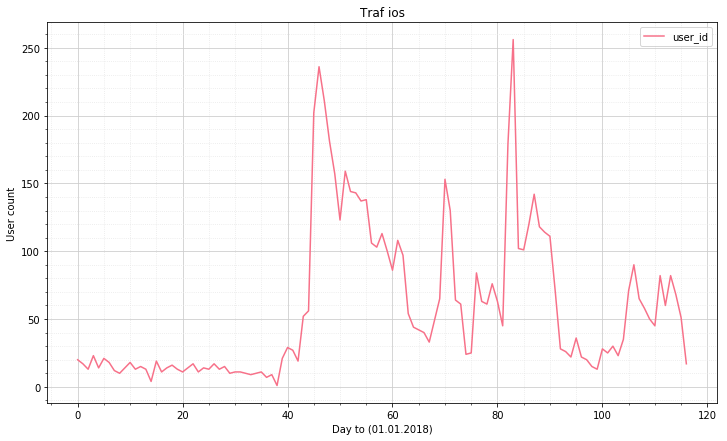

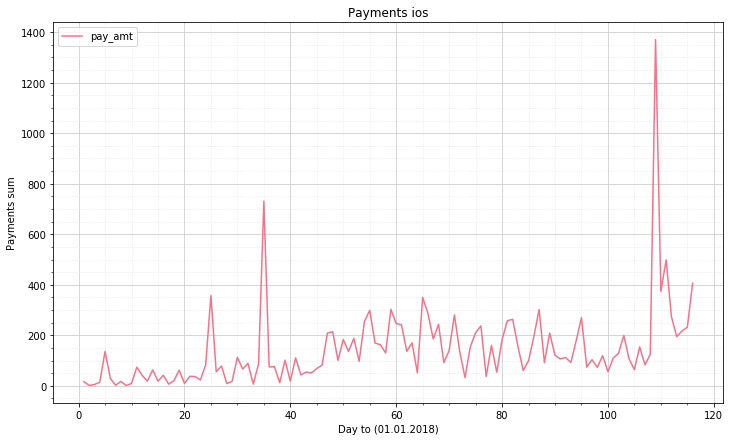

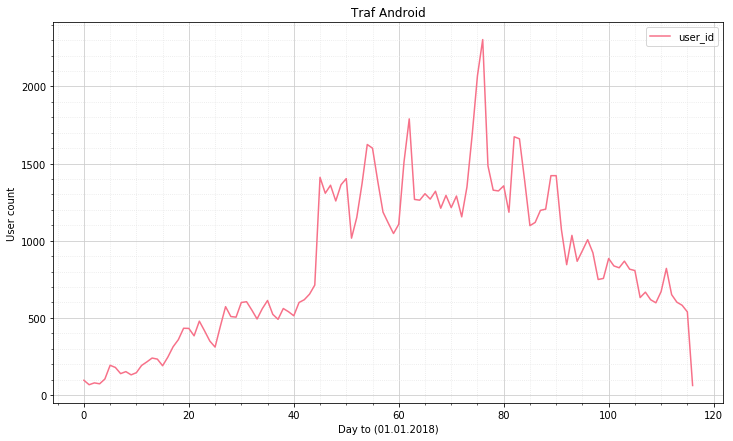

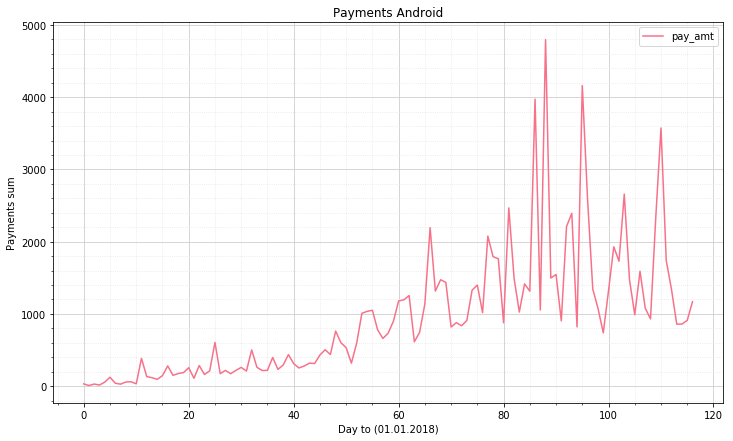

In [560]:
import numpy as np
import pandas as pd
import re
import shutil
import os
import errno
import numpy as np

import calendar
from datetime import datetime
import time
import pytz
import warnings
from scipy.optimize import curve_fit, OptimizeWarning

import dwhimpalautil
import onelinkapi

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
%matplotlib inline
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

cnt_arpu = {}


def to_ut(x, fmt='%Y-%m-%d %H:%M:%S'):
    if x=='nan':
        return None
    else:
        return calendar.timegm(datetime.strptime(x, fmt).timetuple())

def get_ut(year, month, day):
    return  calendar.timegm(datetime(year, month, day).timetuple())

for platform in ['ios','Android']:
    print('\n')
    print(platform+':')
    print('\n')
    with ShowContext('Traf %s' % platform, 'Day to (01.01.2018)', 'User count') as sc:
        
        profiles_tmp = profiles[profiles['platform']==platform]
        p2 = profiles_tmp.copy()
        
        #p2['day'] - сколько дней прошло с 1-го числа на момент регистрации
        
        p2['day'] = (p2['login_first_ts'] - get_ut(2018,1,1))//(24*3600)
        data = p2.groupby('day')['user_id'].count().reset_index()
        plt.plot(data['day'], data['user_id'])
        
        cnt = p2.groupby('reg_country_name')['user_id'].count().sort_values(ascending=False)
        
        print('Total_cnt_of_regs')
        print('\n')
        print(cnt[cnt>500])
        print('\n')
        
    with ShowContext('Payments %s' % platform, 'Day to (01.01.2018)', 'Payments sum') as sc:
        print('total_sum_of_pays')
        print('\n')
        pays_tmp = pays[pays['platform']==platform]
        pays2 = pays_tmp.copy()
        pays2 = pd.merge(pays2, profiles[['user_id', 'reg_country_name', 'login_first_ts']], on='user_id')
        
        #pays2['day'] - сколько дней прошло с 1-го числа на момент платежа
        
        pays2['day'] = (pays2['pay_time'] - get_ut(2018,1,1))//(24*3600)
        
        # pay_day - показатель следующий, показывающий на какой день
        # после регистрации поступил платеж
        
        pays2['pay_day'] = (pays2['pay_time'] - pays2['login_first_ts'])//(24*3600)
        
        data = pays2.groupby('day')['pay_amt'].sum().reset_index()
        plt.plot(data['day'], data['pay_amt'])  
        sums = pays2.groupby('reg_country_name')['pay_amt'].sum().sort_values(ascending=False)
        
        # sums of pays more than 100 USD
        
        print(sums[sums>1000])
        print('\n')
    res = pd.merge(p2.query('day<1500').groupby('reg_country_name'
                                             )['user_id'].count().sort_values(ascending=False).reset_index(), 
                   pays2.query('pay_day<1000').groupby('reg_country_name'
                                                    )['pay_amt'].sum().sort_values(ascending=False).reset_index(),
                   on='reg_country_name').sort_values('pay_amt', ascending=False)
    res['arpu'] = res['pay_amt']/res['user_id']
    res = res.query('user_id>0')
    cnt_arpu[platform] = res
    print('Arpu')
    
    print('\n')
    
    print(res.query('user_id>100'))
    
    print('\n')

In [561]:
cnt_arpu_ios = cnt_arpu['ios']
cnt_arpu_ios.columns = ['reg_country_name','users_cnt','pay_amt_sum','arpu']
cnt_arpu_android = cnt_arpu['Android']
cnt_arpu_android.columns = ['reg_country_name','users_cnt','pay_amt_sum','arpu']

In [562]:
# with ShowContext('7-14 dist', 'part7', 'part14', figsize=(9,7)) as sc:
#     plt.plot(cnt_arpu_ios['users_cnt'], cnt_arpu_ios['pay_amt_sum'], 'o', label = cnt_arpu_ios['reg_country_name'])

# Clustering



ios




/home/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind



training


            reg_country_name        k7       k14  cnt_7     grp
1  Соединенные Штаты Америки  2.111082  2.408633    980  tier_1
2                   Германия  1.767237  2.525320    485  tier_1
4                    Франция  1.457692  2.000062    325  tier_1
5                     Канада  2.092632  2.335120    209  tier_1
6                     Швеция  1.219933  1.965467    150  tier_1
9                  Австралия  1.294261  1.443304    115  tier_1


  reg_country_name        k7       k14  cnt_7     grp
7          Украина  7.278239  7.327324    142  tier_2


  reg_country_name        k7       k14  cnt_7     grp
0           Россия  0.641775  0.932242   3109  tier_3
3   Великобритания  0.913541  0.957479    353  tier_3
8           Италия  0.247154  0.279593    123  tier_3




predicted




/home/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


   reg_country_name        k7       k14  cnt_7     grp
12         Беларусь  1.767424  1.803485     66  tier_1
20   Новая Зеландия  1.347000  1.347000     20  tier_1
21          Австрия  1.645333  1.645333     15  tier_1
30         Хорватия  2.495000  4.485000      2  tier_1


     reg_country_name        k7        k14  cnt_7     grp
25              Китай  37.49625  53.743750      8  tier_2
26          Финляндия   4.58000   4.801667      6  tier_2
29  Саудовская Аравия  19.49000  19.490000      2  tier_2
31           Маврикий  13.78000  13.780000      1  tier_2


       reg_country_name        k7       k14  cnt_7     grp
10                Дания  0.584625  0.748125     80  tier_3
11              Вьетнам  0.162125  0.162125     80  tier_3
13           Нидерланды  0.596491  0.620000     57  tier_3
14              Бельгия  0.240870  0.240870     46  tier_3
15             Ирландия  0.246154  0.246154     39  tier_3
16               Польша  0.050690  0.242414     29  tier_3
17             Бра

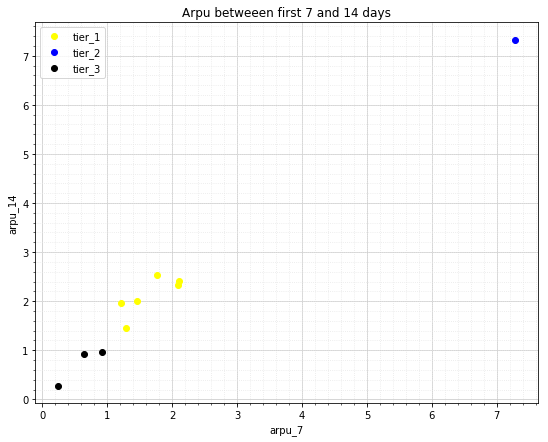

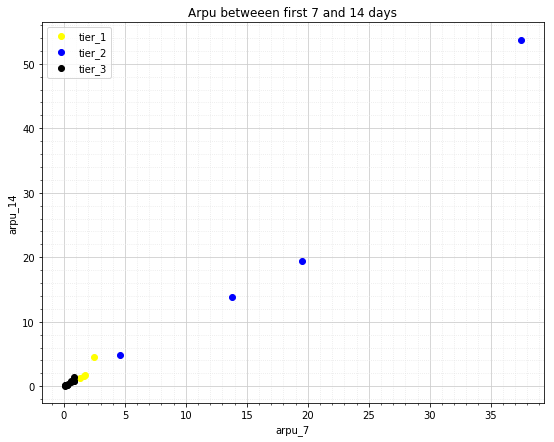



Android




training


                                 reg_country_name        k7       k14  cnt_7  \
3                                        Германия  1.324570  1.691460   4665   
4                       Соединенные Штаты Америки  1.328923  1.613387   4130   
31                                        Австрия  2.595761  4.029442    394   
34                                         Швеция  1.714548  2.590211    332   
42                                        Израиль  1.755321  2.121789    218   
45                                          Дания  1.949611  3.192111    180   
47  Алжирская Народная Демократическая Республика  2.282579  2.282579    159   
48                                      Швейцария  2.856301  3.444247    146   
56                                        Эстония  2.313193  2.550084    119   
58                         Палестинская автономия  1.877193  1.877193    114   

       grp  
3   tier_1  
4   tier_1  
31  tier_1  
34  tier_1  
42  tier_1  
45  tier_1  
47 

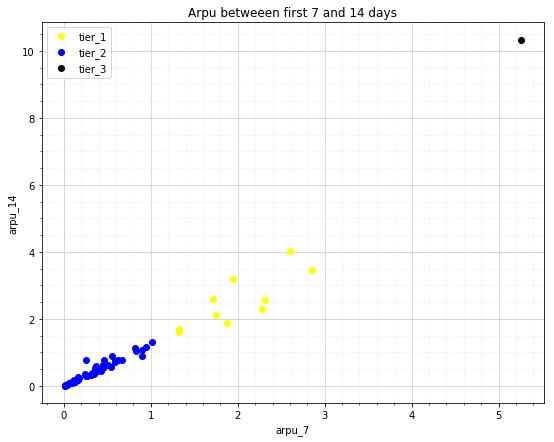

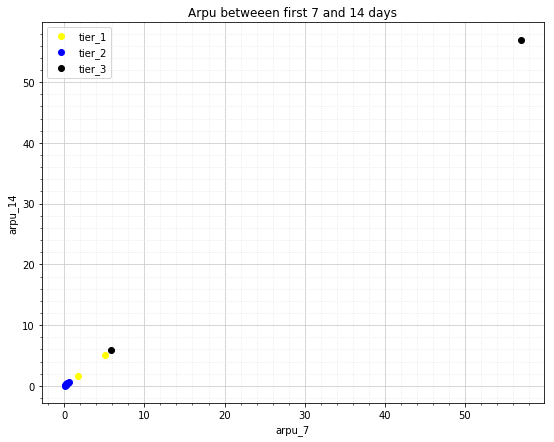

In [563]:
NOW = get_ut(2018, 5, 30)
START = get_ut(2017, 10, 1)
d_list = [7, 14]
MAX_NUM = 30
users_cnt=100

TIER_NUM = 3

clusters = {}
%matplotlib notebook
%matplotlib inline
for platform in ['ios','Android']:
    print('\n')
    print(platform)
    print('\n')
    profiles_tmp = profiles[profiles['platform']==platform]
    p2 = profiles_tmp.copy()
    
    pays_tmp = pays[pays['platform']==platform]
    pays2 = pays_tmp.copy()
    
    pays2 = pd.merge(pays2, profiles_tmp[['user_id', 'reg_country_name', 'login_first_ts']], on='user_id')
    pays2['pay_day'] = (pays2['pay_time'] - pays2['login_first_ts'])//(24*3600)
    
    res_list = []
    for num in d_list:
        res = pd.merge(p2.loc[(p2['login_first_ts'] >= START) &
                              (p2['login_first_ts'] < NOW - MAX_NUM*24*3600)].groupby('reg_country_name'
                                                 )['user_id'].count().sort_values(ascending=False).reset_index(), 
                       pays2.query('pay_day<%s' % num).groupby('reg_country_name'
                                                        )['pay_amt'].sum().sort_values(ascending=False).reset_index(),
                       on='reg_country_name').sort_values('user_id', ascending=False
                                                         ).rename(index=str,
                                                                  columns={'user_id': 'cnt_%s' % num})
        res['arpu_%s' % num] = res['pay_amt']/res['cnt_%s' % num]
        res_list.append(res[['reg_country_name', 'arpu_%s' % num, 'cnt_%s' % num]])
    
    res2 = res_list[0]
    
    for df in res_list[1:]:
        res2 = pd.merge(res2, df, how='left', on='reg_country_name')
    
    res2['k7'] = res2['arpu_7']
    res2['k14'] = res2['arpu_14']
    
    train_data_general = res2[res2['cnt_14']>users_cnt]
    test_data_general = res2[res2['cnt_14']<=users_cnt]
    
    
    train_data = res2[res2['cnt_14']>users_cnt][['k7', 'k14']].values      
    test_data = res2[res2['cnt_14']<=users_cnt][['k7', 'k14']].values     
    
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=TIER_NUM, random_state=0).fit(train_data)
    train_data_general['grp'] = kmeans.labels_
    
    
    #print(train_data_general)
    train_data_general['grp'] = train_data_general['grp'].map({0: 'tier_1', 1: 'tier_2', 2:'tier_3'})

    
    print('\n')
    print('training')
    print('\n')
    colors=['yellow','blue','black']
    
    with ShowContext('Arpu betweeen first 7 and 14 days', 'arpu_7', 'arpu_14', figsize=(9,7)) as sc:
        for grp_tmp,color_tmp in zip(np.sort(train_data_general['grp'].unique()),colors):
            
            
            train_data_general_tmp = train_data_general[train_data_general['grp']==grp_tmp]
            plt.plot(train_data_general_tmp['k7'], train_data_general_tmp['k14'],'o', 
                     label = grp_tmp,
                     color = color_tmp)
            
            print(train_data_general_tmp[['reg_country_name','k7','k14','cnt_7','grp']])
            print('\n')
        
    

    
    print('\n')
    print('predicted')
    print('\n')
    
    mylist = kmeans.predict(test_data).tolist()
    
    se = pd.Series(mylist)
    
    test_data_general['grp'] = se.values
    test_data_general['grp'] = test_data_general['grp'].map({0: 'tier_1', 1: 'tier_2', 2:'tier_3'})
    
    with ShowContext('Arpu betweeen first 7 and 14 days', 'arpu_7', 'arpu_14', figsize=(9,7)) as sc:
        for grp_tmp,color_tmp in zip(np.sort(test_data_general['grp'].unique()),colors):
            
            
            test_data_general_tmp = test_data_general[test_data_general['grp']==grp_tmp]
            plt.plot(test_data_general_tmp['k7'], test_data_general_tmp['k14'],'o', 
                     label = grp_tmp,
                     color = color_tmp)
            
            print(test_data_general_tmp[['reg_country_name','k7','k14','cnt_7','grp']])
            print('\n')
        
    
    plt.show()
    data_general = train_data_general.append(test_data_general)
    
    
    data_general = data_general[['reg_country_name','arpu_7','arpu_14','cnt_7','cnt_14','grp']]
    data_general.columns = ['reg_country_name','arpu_7','arpu_14','cnt_7','cnt_14','tier']
    clusters[platform]=data_general[['reg_country_name','arpu_7','arpu_14','cnt_7','cnt_14','tier']]

# Старая рабочая версия

In [369]:
# TIERS = {}
# NOW = get_ut(2018, 4, 30)
# START = get_ut(2017, 10, 1)
# d_list = [7, 14, 30]
# MAX_NUM = 30
# users_cnt=100

# TIER_NUM = 3

# clusters = {}


# for platform in ['ios','Android']:
#     profiles_tmp = profiles[profiles['platform']==platform]
#     p2 = profiles_tmp.copy()
    
#     pays_tmp = pays[pays['platform']==platform]
#     pays2 = pays_tmp.copy()
    
#     pays2 = pd.merge(pays2, profiles_tmp[['user_id', 'reg_country_name', 'login_first_ts']], on='user_id')
#     pays2['pay_day'] = (pays2['pay_time'] - pays2['login_first_ts'])//(24*3600)
    
#     res_list = []
#     for num in d_list:
#         res = pd.merge(p2.loc[(p2['login_first_ts'] >= START) &
#                               (p2['login_first_ts'] < NOW - MAX_NUM*24*3600)].groupby('reg_country_name'
#                                                  )['user_id'].count().sort_values(ascending=False).reset_index(), 
#                        pays2.query('pay_day<%s' % num).groupby('reg_country_name'
#                                                         )['pay_amt'].sum().sort_values(ascending=False).reset_index(),
#                        on='reg_country_name').sort_values('user_id', ascending=False
#                                                          ).rename(index=str,
#                                                                   columns={'user_id': 'cnt_%s' % num})
#         res['arpu_%s' % num] = res['pay_amt']/res['cnt_%s' % num]
#         res_list.append(res[['reg_country_name', 'arpu_%s' % num, 'cnt_%s' % num]])
    
#     res2 = res_list[0]
    
#     for df in res_list[1:]:
#         res2 = pd.merge(res2, df, how='left', on='reg_country_name')
    
#     res2['k7'] = res2['arpu_7']
    
#     res2['k14'] = res2['arpu_14']
    
#     train_data = res2[res2['cnt_14']>users_cnt][['k7', 'k14']].values      
    
#     #test_data = res2[res2['cnt_14']<=users_cnt][['k7', 'k14']].values
    
#     from sklearn.cluster import KMeans
    
#     kmeans = KMeans(n_clusters=TIER_NUM, random_state=0).fit(train_data)
    
#     res2.loc[res2['cnt_14'] > users_cnt, 'grp'] = kmeans.labels_
#     #res2 = kmeans.predict
    
#     #res2_copy = res2
#     #res2_copy.loc[res2_copy['cnt_14'] <= users_cnt, 'grp'] = kmeans.labels_
    
#     #
    
#     #res2 = res2.append(res2_copy)
    
#     #
#     tiers = res2.groupby('grp')['k14'].mean().sort_values(ascending=False).reset_index()[['grp']]
    
#     tiers['tier'] = ['tier_%s' % (n + 1) for n in range(TIER_NUM)]
    
#     res2 = pd.merge(res2, tiers, how='left', on='grp').sort_values('tier')
    
#     data = res2[res2['cnt_14']>0].iloc[:]
#     data['platform'] = platform

    
#     with ShowContext('7-14 dist', 'part7', 'part14', figsize=(9,7)) as sc:
#         for country, data2 in data.groupby('reg_country_name'):
#             plt.plot(data2['k7'], data2['k14'], 'o', label=country)
    
#     with ShowContext('7-14 dist', 'part7', 'part14', figsize=(9,7)) as sc:
#         for tier, data2 in data.groupby('tier'):
#             plt.plot(data2['k7'], data2['k14'],
#                      #'o',
#                      label=tier)
            
#     #profiles_tmp = profiles_tmp[['reg_country_name']].merge(res2, how='left')
#     #profiles_tmp = profiles_tmp.drop_duplicates()
#     #profiles_tmp['tier'] = profiles_tmp['tier'].fillna('--')
    
#     #print(res2[res2['tier'].notnull()][['reg_country_name','tier','k7','k14','cnt_7','cnt_14']])
#     #clusters[platform]=res2[['reg_country_name','tier','k7','k14','cnt_7','cnt_14']].fillna('no_tier')

In [566]:
MIN_TS = get_ut(2017,9,1)
COH_SIZE = 1# В днях
COH_START = get_ut(2017,9,1)
COH_END = get_ut(2018,4,25)
PAYS_END = get_ut(2018, 4, 23)

%matplotlib inline

#ltv=pd.DataFrame(columns=['ltv_day'])
#ltv_dict = {}
def func(x, a, b, c):
#     return 50*np.tanh(a)*np.log(x + 500*np.tanh(b)) + 100*np.tanh(c)
    return a*np.log(x + 100*np.tanh(b)) + c

def get_cohs(profiles, payments, platform):
    # Add Tiers
    profiles = profiles[profiles['platform']==platform]
    profiles = profiles.merge(clusters[platform], how='left')      
    # Add cohorts numbers
    profiles['coh'] = (profiles['login_first_ts'] - MIN_TS) // (COH_SIZE*3600*24)
    profiles = profiles.loc[profiles['coh'] >= 0]
    
    cohs_sizes = profiles.groupby(['coh', 'tier']
                                 ).agg({'user_id': 'nunique', 
                                        'login_first_ts': 'max'}
                                      ).reset_index().rename(index=str, columns={'user_id': 'coh_size'})
    cohs_sizes['last_day'] = max(payments['pay_time'].max(), cohs_sizes['login_first_ts'].max())
    cohs_sizes['max_day'] = (cohs_sizes['last_day'] - cohs_sizes['login_first_ts']) // (24*3600)
    cohs_sizes = cohs_sizes[['coh', 'tier', 'coh_size', 'max_day']]

    zeros_df = pd.concat([pd.DataFrame({'coh': coh, 
                                        'tier': tier, 
                                        'coh_size': coh_size,
                                        'days_passed': list(range(int(max_day)+1))
                      }) for idx, (coh, tier, coh_size, max_day) in cohs_sizes.iterrows()])
        
    project = pd.merge(profiles, payments, on='user_id') 
    project['days_passed'] = (project['pay_time'] - project['login_first_ts']) // (24*3600)
        
    project_sum = project.groupby(['coh', 'tier', 'days_passed'])['pay_amt'].sum().reset_index()
    project_sum = pd.merge(zeros_df, project_sum, on=['coh', 'tier', 'days_passed'], how='left').fillna(0)    
    return project, cohs_sizes, project_sum
    
    
def predict_LTV(profiles0, payments0, platform):
    profiles = profiles0.copy()
    payments = payments0.copy()
    ltv={}
    res_popt = {}
    project, cohs_sizes, project_sum = get_cohs(profiles, payments, platform)    
    for tier in project.groupby('tier')['user_id'].nunique().sort_values(ascending=False
                                                                        ).reset_index()['tier']:
        
        
        print(clusters[platform][clusters[platform]['tier']==tier])
        #print()
        project_sum_upd = project_sum.loc[project_sum['tier'] == tier]
        #------------------Построение-через-усредненную-кривую-------------------------------------------------------
        data_avg = project_sum_upd.groupby('days_passed').agg({'pay_amt': 'sum', 
#                                                                'revenue': 'sum',
                                                               'coh_size': 'sum'}).reset_index()
        data_avg['ARPU'] = data_avg['pay_amt'] / data_avg['coh_size']
        data_avg['LTV'] = data_avg['ARPU'].cumsum() #/ 60
#         data_avg['LTV'] = data_avg['revenue']/data_avg['coh_size']
        data_avg['sigma'] = 1 / (data_avg['coh_size']**0.5)
        
        #------------------Построение-через-усреднение-кривых-всех-когорт--------------------------------------------
        data_mean_all = project_sum_upd.copy()
        data_mean_all['cum_sum'] = project_sum_upd.groupby(['coh', 'tier'])['pay_amt'].cumsum()
        data_mean_all['LTV'] = data_mean_all['cum_sum'] / data_mean_all['coh_size']
        data_mean_all['LTV'] = data_mean_all['LTV'] #/ 60
        data_mean_all['sigma'] = 1 / (data_mean_all['coh_size'])**0.5
        
#     #Колонка sigma (по сути, это веса) - для учета размеров когорт и их вклада в общее предсказание
#     #Т.к. используем веса, не нужно выбрасывать когорты малого размера - эти, возможно, выбросы все равно будут слабо влиять
        
        n_players = int(project_sum_upd[['coh', 'coh_size']].drop_duplicates()['coh_size'].sum())
        
        #Рассмотрим кол-во игроков >300
        if (n_players > 0):
            title = '%s: %s, n_players = %s' % (platform, tier, str(n_players))
            with ShowContext(title, 'Days', 'LTV USD', show_legend=False, figsize=(9,7)) as sc:
                
                sns.set_palette(sns.color_palette('husl', project_sum_upd['coh'].nunique()))
                for coh, group in data_mean_all.groupby('coh'):
                    coh_cnt = int(cohs_sizes.loc[(cohs_sizes['coh'] == coh) &
                                                 (cohs_sizes['tier'] == tier)]['coh_size'])
                    plt.plot(group['days_passed'], group['LTV'],
                             alpha = coh_cnt / project_sum_upd['coh_size'].max())
                
                
                
                plt.plot(data_avg['days_passed'], data_avg['LTV'], linewidth=5, color='green')
                
                Q=1.645
                delta = data_avg['LTV'] * Q * data_avg['sigma']
                plt.fill_between(data_avg['days_passed'], data_avg['LTV']-delta, data_avg['LTV']+delta,
                                color='green', alpha=0.4)
                popt, pcov = curve_fit(func, data_avg['days_passed'], data_avg['LTV'].astype('float'),
                              sigma=data_avg['sigma'], absolute_sigma=True, maxfev = 100000, p0=(1,1,-1))
    
                
                days = np.linspace(0, 360, 361)
                LTV = [func(x, *popt) for x in days]   #Взвешенное среднее всех когорт
                
                plt.plot(days, LTV, linewidth=3, color='orange', linestyle=':')

                plt.ylim((0,func(360, *popt)*1.1))
                plt.show()
                
        ltv[tier]=LTV
        #ltv['ltv_day'] = ltv.index
        res_popt[tier] = popt

    return res_popt, ltv


       reg_country_name    arpu_7   arpu_14  cnt_7  cnt_14    tier
0                Россия  0.641775  0.932242   3109    3109  tier_3
3        Великобритания  0.913541  0.957479    353     353  tier_3
8                Италия  0.247154  0.279593    123     123  tier_3
10                Дания  0.584625  0.748125     80      80  tier_3
11              Вьетнам  0.162125  0.162125     80      80  tier_3
13           Нидерланды  0.596491  0.620000     57      57  tier_3
14              Бельгия  0.240870  0.240870     46      46  tier_3
15             Ирландия  0.246154  0.246154     39      39  tier_3
16               Польша  0.050690  0.242414     29      29  tier_3
17             Бразилия  0.172069  0.172069     29      29  tier_3
18  Республика Сингапур  0.810357  0.810357     28      28  tier_3
19              Румыния  0.839091  1.440909     22      22  tier_3
22              Гонконг  0.324000  0.324000     15      15  tier_3
23              Венгрия  0.092000  0.092000     15      15  ti

/home/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


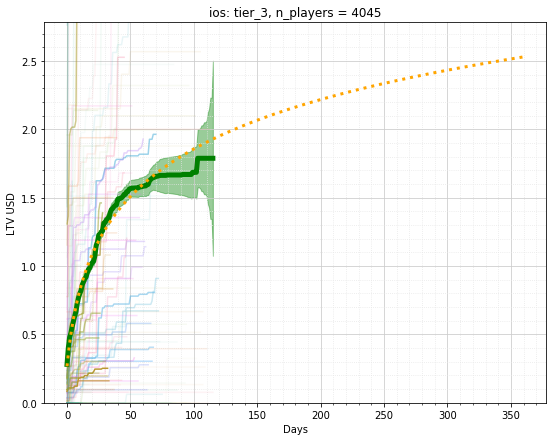

             reg_country_name    arpu_7   arpu_14  cnt_7  cnt_14    tier
1   Соединенные Штаты Америки  2.111082  2.408633    980     980  tier_1
2                    Германия  1.767237  2.525320    485     485  tier_1
4                     Франция  1.457692  2.000062    325     325  tier_1
5                      Канада  2.092632  2.335120    209     209  tier_1
6                      Швеция  1.219933  1.965467    150     150  tier_1
9                   Австралия  1.294261  1.443304    115     115  tier_1
12                   Беларусь  1.767424  1.803485     66      66  tier_1
20             Новая Зеландия  1.347000  1.347000     20      20  tier_1
21                    Австрия  1.645333  1.645333     15      15  tier_1
30                   Хорватия  2.495000  4.485000      2       2  tier_1


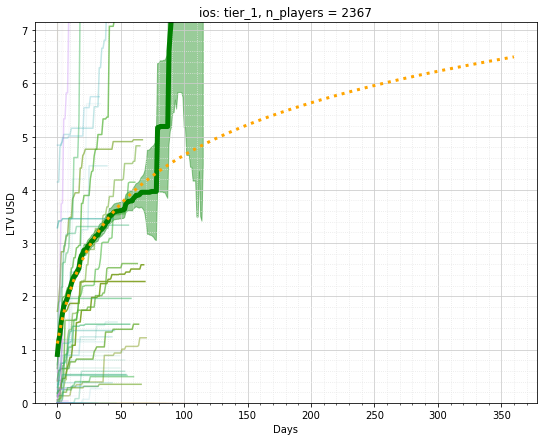

     reg_country_name     arpu_7    arpu_14  cnt_7  cnt_14    tier
7             Украина   7.278239   7.327324    142     142  tier_2
25              Китай  37.496250  53.743750      8       8  tier_2
26          Финляндия   4.580000   4.801667      6       6  tier_2
29  Саудовская Аравия  19.490000  19.490000      2       2  tier_2
31           Маврикий  13.780000  13.780000      1       1  tier_2


/home/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


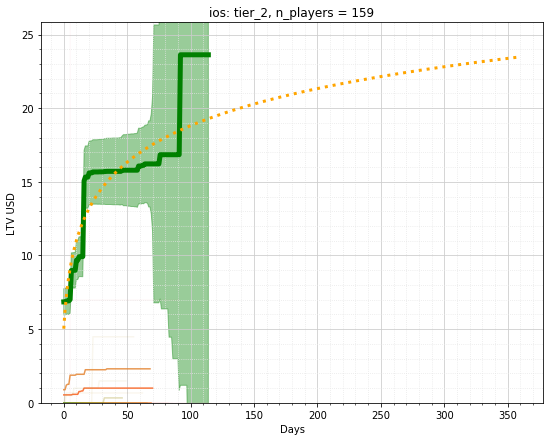

                 reg_country_name    arpu_7   arpu_14  cnt_7  cnt_14    tier
0                          Россия  0.587859  0.724606  30147   30147  tier_2
1                         Украина  0.323691  0.371540   6557    6557  tier_2
2                       Индонезия  0.620008  0.771432   5230    5230  tier_2
5                        Бразилия  0.176110  0.246855   3905    3905  tier_2
6                         Франция  1.010633  1.315798   3272    3272  tier_2
7                            Ирак  0.122354  0.122354   3212    3212  tier_2
8                          Польша  0.381300  0.451458   2976    2976  tier_2
9                        Беларусь  0.130139  0.169594   2585    2585  tier_2
10                        Вьетнам  0.072943  0.090680   1913    1913  tier_2
11                         Италия  0.818226  1.144124   1804    1804  tier_2
12                        Таиланд  0.347279  0.350595   1797    1797  tier_2
13                          Индия  0.089879  0.090451   1730    1730  tier_2

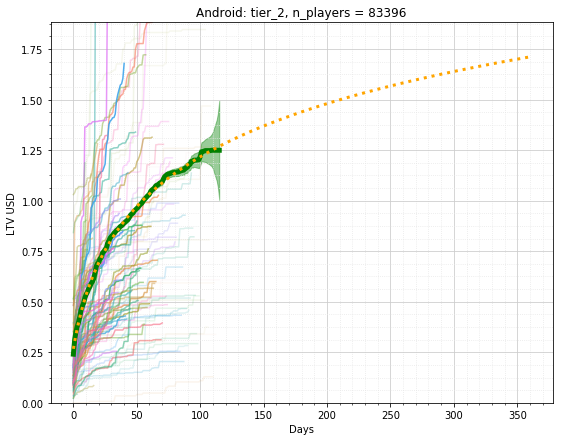

                                 reg_country_name    arpu_7   arpu_14  cnt_7  \
3                                        Германия  1.324570  1.691460   4665   
4                       Соединенные Штаты Америки  1.328923  1.613387   4130   
31                                        Австрия  2.595761  4.029442    394   
34                                         Швеция  1.714548  2.590211    332   
42                                        Израиль  1.755321  2.121789    218   
45                                          Дания  1.949611  3.192111    180   
47  Алжирская Народная Демократическая Республика  2.282579  2.282579    159   
48                                      Швейцария  2.856301  3.444247    146   
56                                        Эстония  2.313193  2.550084    119   
58                         Палестинская автономия  1.877193  1.877193    114   
69                              Тринидад и Тобаго  5.039062  5.039062     32   
73                                      

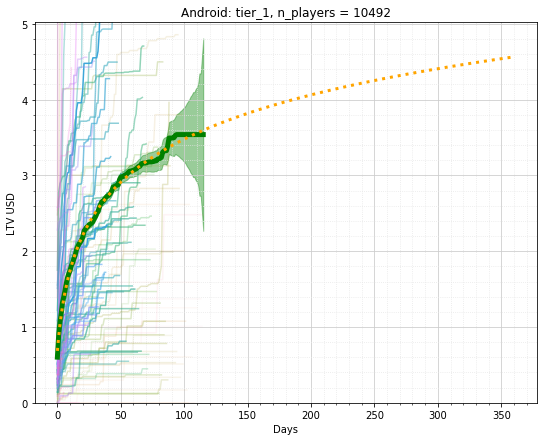

     reg_country_name    arpu_7   arpu_14  cnt_7  cnt_14    tier
54           Норвегия   5.26000  10.33438    121     121  tier_3
72  Багамские острова   5.84875   5.84875      8       8  tier_3
74          Свазиленд  57.00000  57.00000      1       1  tier_3


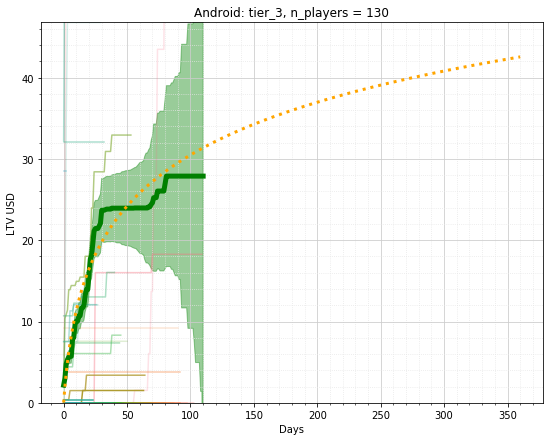

In [567]:
res_popt = {}
ltv_dict = {}
for platform in ['ios','Android']:
    
    profiles_tmp = profiles[profiles['platform']==platform]
    pays_tmp = pays[pays['platform']==platform]
    res_popt, ltv = predict_LTV(profiles_tmp, pays_tmp, platform)
    ltv_dict.update({platform:ltv})

In [455]:
android = pd.DataFrame(ltv_dict['Android'])
android = android.add_prefix('android_')
android['ltv_day'] = android.index

In [456]:
ios = pd.DataFrame(ltv_dict['ios'])
ios = ios.add_prefix('ios_')
ios['ltv_day'] = ios.index

In [457]:
ltv = android.merge(ios)

In [478]:
result = ltv.loc[[1,2,3,5,7,14,30,90,180,360]].T
result.columns = ['ltv_1',
                  'ltv_2',
                  'ltv_3',
                  'ltv_5',
                  'ltv_7',
                  'ltv_14',
                  'ltv_30',
                  'ltv_90','ltv_180','ltv_360']
result['ltv_360_1'] = result['ltv_360']/result['ltv_1']
result['ltv_360_2'] = result['ltv_360']/result['ltv_2']
result['ltv_360_3'] = result['ltv_360']/result['ltv_3']
result['ltv_360_5'] = result['ltv_360']/result['ltv_5']
result['ltv_360_7'] = result['ltv_360']/result['ltv_7']
result['ltv_360_14'] = result['ltv_360']/result['ltv_14']
result['ltv_360_30'] = result['ltv_360']/result['ltv_30']
result['ltv_360_90'] = result['ltv_360']/result['ltv_90']
result['ltv_360_180'] = result['ltv_360']/result['ltv_180']

result = result.loc[['android_tier_1',
           'android_tier_2',
           'android_tier_3',
           'ios_tier_1',
           'ios_tier_2',
           'ios_tier_3']]

result = result.T

In [503]:
# clusters['Android']
# clusters['ios']

In [482]:
result

,android_tier_1,android_tier_2,android_tier_3,ios_tier_1,ios_tier_2,ios_tier_3
ltv_1,0.497030,0.143253,1.226402,0.416143,1.367461,6.489305
ltv_2,0.556854,0.164944,1.572143,0.489097,1.533190,7.442456
ltv_3,0.611762,0.182212,1.870481,0.555831,1.676624,8.206390
ltv_5,0.709659,0.208830,2.367024,0.674339,1.916094,9.391026
ltv_7,0.795035,0.229074,2.771181,0.777251,2.111585,10.296411
ltv_14,1.029277,0.276246,3.785228,1.057918,2.603793,12.416787
ltv_30,1.374366,0.334044,5.126543,1.468167,3.257381,15.027487
ltv_90,1.990158,0.423097,7.310391,2.194901,4.324703,19.063251
ltv_180,2.420282,0.480915,8.765265,2.700491,5.036785,21.687382
ltv_360,2.866406,0.539293,10.247639,3.224071,5.762708,24.338276


In [543]:
# IOS

top 5% players gives 70.9958886893 % of general revenue
top 10% players gives 82.593851512 % of general revenue


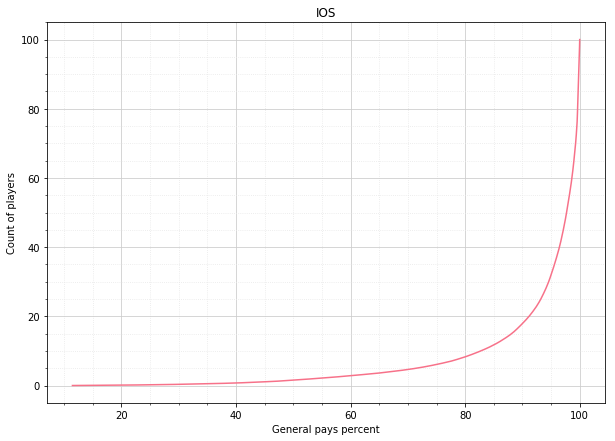

In [545]:
df = profiles_ios.merge(pays_ios)
data = df.groupby('user_id')['pay_amt'].sum().reset_index().sort_values(by = 'pay_amt',ascending=False)
data['pay_amt_cum'] = 100*data['pay_amt'].cumsum()/data['pay_amt'].sum()
data = data.reset_index()
data['index'] = data.index
data['index_cum'] = 100*data['index']/data['index'].max()


title = 'IOS'
with ShowContext(title, 'General pays percent', 'Count of players', show_legend=False, figsize=(10,7)) as sc:
    plt.plot(data['pay_amt_cum'], data['index_cum'])
    #plt.plot([100, 0], [5, 5], 'k-', lw=2)
    print('top 5% players gives',data.query('index_cum<5').iloc[-1]['pay_amt_cum'],'% of general revenue')
    print('top 10% players gives',data.query('index_cum<10').iloc[-1]['pay_amt_cum'],'% of general revenue')

In [547]:
# android

top 5% of players gives 56.9499699198 % of general revenue
top 10% of players gives 69.5102051978 % of general revenue


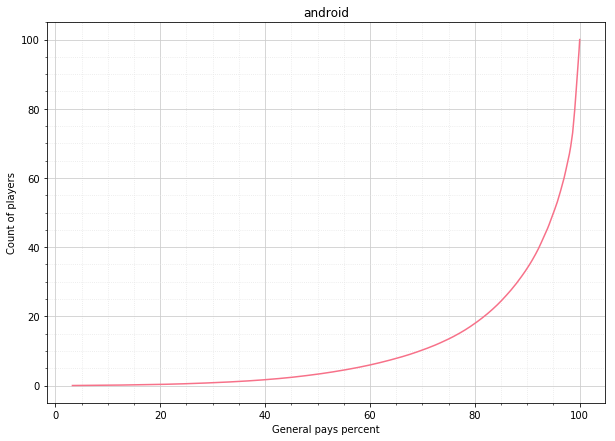

In [549]:
df = profiles_android.merge(pays_android)
data = df.groupby('user_id')['pay_amt'].sum().reset_index().sort_values(by = 'pay_amt',ascending=False)
data['pay_amt_cum'] = 100*data['pay_amt'].cumsum()/data['pay_amt'].sum()
data = data.reset_index()
data['index'] = data.index
data['index_cum'] = 100*data['index']/data['index'].max()


title = 'android'
with ShowContext(title, 'General pays percent', 'Count of players', show_legend=False, figsize=(10,7)) as sc:
    plt.plot(data['pay_amt_cum'], data['index_cum'])
    #plt.plot([100, 0], [5, 5], 'k-', lw=2)
    print('top 5% of players gives',data.query('index_cum<5').iloc[-1]['pay_amt_cum'],'% of general revenue')
    print('top 10% of players gives',data.query('index_cum<10').iloc[-1]['pay_amt_cum'],'% of general revenue')

In [572]:
KMeans.__dict__

mappingproxy({'__doc__': 'K-Means clustering\n\n    Read more in the :ref:`User Guide <k_means>`.\n\n    Parameters\n    ----------\n\n    n_clusters : int, optional, default: 8\n        The number of clusters to form as well as the number of\n        centroids to generate.\n\n    init : {\'k-means++\', \'random\' or an ndarray}\n        Method for initialization, defaults to \'k-means++\':\n\n        \'k-means++\' : selects initial cluster centers for k-mean\n        clustering in a smart way to speed up convergence. See section\n        Notes in k_init for more details.\n\n        \'random\': choose k observations (rows) at random from data for\n        the initial centroids.\n\n        If an ndarray is passed, it should be of shape (n_clusters, n_features)\n        and gives the initial centers.\n\n    n_init : int, default: 10\n        Number of time the k-means algorithm will be run with different\n        centroid seeds. The final results will be the best output of\n        n_ini

In [1]:
TIERS = {'ios': {'RU': ['Russia'],
                 'US+DE+FR' : ['United States', 'Germany', 'France']},
        'android': {'RU': ['Russia'], 
                    'US': ['United States'], 
                    'DE': ['Germany'], 
                    'UK': ['United Kingdom'], 
                    'BR+IZ+VN+TH': ['Brazil', 'Indonesia', 'Vietnam', 'Thailand'], 
                    'PO+FR+IT+SP': ['Poland', 'France', 'Italy', 'Spain'] }}